# How to:
## Use `jacked` for line finding. 

`jacked` can be used in a variaty of ways. Here, we show how to use the jackknifed data sets for inference of a line detection. According to JWST data, In the ALMA data we have been working with, there should be [OIII] emission coming from a galaxy which some 14 Billion light years away. Let's see if we can find it, or if it is undistinguishable from noise.

The line finding is done with a code named [Source EXtractor](https://www.astromatic.net/software/sextractor/). Source extractor is integrated in a Python interface through the [`Interferopy` package](https://interferopy.readthedocs.io/en/latest/). Sadly, Interferopy is restricts the usage of Python version (>3.6 and <3.10), meaning we can't integrate it with `jacked` since `jacked` works in the visibillity plane, therefore it needs to use the package `casatasks` which limits the Python version to Python=3.6. Therefore, we ran the linefinding seperately, but you can you find the output catalogs also on the [google drive](https://drive.google.com/file/d/1FlQNwy7VtAk0zcFfdW5tMY2aGKivxlyR/view?usp=sharing) and the script we used to generate the outputs in the same folder as the tutorials. 

Let's first load in everythinbg. 

### Load in 

In [1]:
import os
import numpy as np
from scipy import stats
from astropy.io import ascii
from astropy import constants as c
from astropy import units as u
from astropy.modeling import models

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
# load in all catalogs
# change directory depending on where you downloaded it
path0 = '../../output/findclumps/Glass-z13/' 
path1 = '../../output/findclumps/Glass-z13_Jacked_seed42/'
path2 = '../../output/findclumps/Glass-z13_Jacked_seed142/'
path3 = '../../output/findclumps/Glass-z13_Jacked_seed242/'
path4 = '../../output/findclumps/Glass-z13_Jacked_seed243/'
path5 = '../../output/findclumps/Glass-z13_Jacked_seed244/'

cat_N = 'findlcumps_clumpsN_minSNR_-2.cat'
cat_P = 'findlcumps_clumpsP_minSNR_-2.cat'

data_real_N = ascii.read(path0+cat_N)
data_jack1_N = ascii.read(path1+cat_N)
data_jack2_N = ascii.read(path2+cat_N)
data_jack3_N = ascii.read(path3+cat_N)
data_jack4_N = ascii.read(path4+cat_N)
data_jack5_N = ascii.read(path5+cat_N)

data_real_P = ascii.read(path0+cat_P)
data_jack1_P = ascii.read(path1+cat_P)
data_jack2_P = ascii.read(path2+cat_P)
data_jack3_P = ascii.read(path3+cat_P)
data_jack4_P = ascii.read(path4+cat_P)
data_jack5_P = ascii.read(path5+cat_P)

In [3]:
# append the jackknifed cubed into one sample
data_jack_N = np.hstack((data_jack1_N['SNR'], data_jack2_N['SNR'], data_jack3_N['SNR'], data_jack4_N['SNR'], data_jack5_N['SNR']))
data_jack_P = np.hstack((data_jack1_P['SNR'], data_jack2_P['SNR'], data_jack3_P['SNR'], data_jack4_P['SNR'], data_jack5_P['SNR']))

This is how a single catalog looks like. 

In [4]:
data_real_P

RA,DEC,FREQ_GHZ,X,Y,SNR,FLUX_MAX,BINNING
float64,float64,float64,float64,float64,float64,float64,int64
3.49891,-30.32509,253.8213,589.5,123.5,1.76,0.000429,3
3.49919,-30.32517,253.8213,302.1,29.4,1.44,0.00035,3
3.49938,-30.32519,253.8213,101.7,2.0,1.61,0.000392,3
3.49878,-30.32457,253.8213,723.3,747.3,3.5,0.000851,3
3.49858,-30.32437,253.8213,935.0,988.3,3.14,0.000764,3
3.49878,-30.32434,253.8213,720.4,1020.6,2.23,0.000544,3
3.49852,-30.32457,253.8213,996.8,751.3,1.91,0.000464,3
3.49916,-30.32461,253.8213,327.7,696.9,3.5,0.000851,3
3.49931,-30.32458,253.8213,176.4,741.1,2.03,0.000494,3


## Plot sampled probabillity functions

As explained in [Vio & Andreani 2016](https://arxiv.org/abs/1602.02392), the underlying distribution that sets the likelihood of false detection is the distribution of peaks of a smoothed (close to) Gaussian random field. With the jackedknifed measurment sets we effectively resample this distribution. This is more complete and more acurately than, for isntance, using the distribution of negative peak values as used in [Walter+2016](https://arxiv.org/abs/1607.06768). 

### Comparing the two noise distribution
Below we show the comparison between the linefind results done on the jackknifed cubes (with postive and negative peak values) and the distribution of negative peak values from the real data.

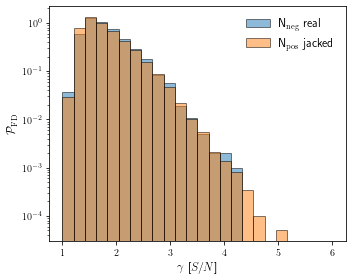

In [5]:
plt.figure(figsize=(5,4))
plt.hist(data_real_N['SNR'], bins = np.linspace(1, 6, 25), density = True, alpha = 0.5, edgecolor='black', label = r'N$_{\rm neg}$ real', color = 'C0')
plt.hist(data_jack_P,        bins = np.linspace(1, 6, 25), density = True, alpha = 0.5, edgecolor='black', label = r'N$_{\rm pos}$ jacked', color = 'C1')

plt.xlabel(r'$\gamma$ [$S/N$]', fontsize = 12)
plt.ylabel(r'$\mathcal{P}_{\rm FD}$', fontsize = 12)
plt.legend(frameon=False, fontsize = 12)

plt.semilogy()
plt.tight_layout()
plt.savefig('../../plots/neg_vs_pos.pdf', dpi = 300)
plt.show()

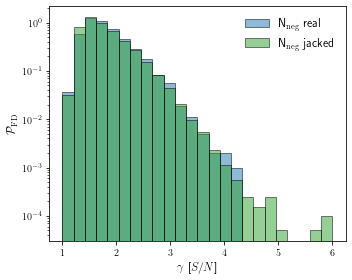

In [6]:
plt.figure(figsize=(5,4))
plt.hist(data_real_N['SNR'], bins = np.linspace(1, 6, 25), density = True, alpha = 0.5, edgecolor='black', label = r'N$_{\rm neg}$ real', color = 'C0')
plt.hist(data_jack_N       , bins = np.linspace(1, 6, 25), density = True, alpha = 0.5, edgecolor='black', label = r'N$_{\rm neg}$ jacked', color = 'C2')

plt.xlabel(r'$\gamma$ [$S/N$]', fontsize = 12)
plt.ylabel(r'$\mathcal{P}_{\rm FD}$', fontsize = 12)
plt.legend(frameon=False, fontsize = 12)

plt.semilogy()
plt.tight_layout()
plt.savefig('../../plots/neg_vs_neg.pdf', dpi = 300)
plt.show()

We can do a quick statistical to verify if the two distributions are drawn from the same distribution. 

In [7]:
print('p-value = {:.5f}'.format(stats.ks_2samp(data_real_N['SNR'],data_jack_N).pvalue))
print('p-value = {:.5f}'.format(stats.ks_2samp(data_real_N['SNR'],data_jack_P).pvalue))

p-value = 0.00000
p-value = 0.00000


The null hypothesis that the two random samples come from the same distribution can be rejected

### Detection inference

Now let's compare the noise distribution --- drawn fromt the jackknifed data sets --- with the positive peak distribution of the real initial data set. Since the astronomical signal is positive and any peak larger than our noise distribution can be considered true. 

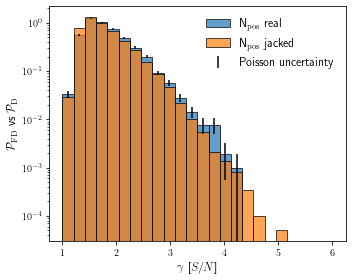

In [8]:
plt.figure(figsize=(5,4))
bins_D  = plt.hist(data_real_P['SNR'], bins = np.linspace(1, 6, 25), density = True, alpha = 0.7, edgecolor='black', label = r'N$_{\rm pos}$ real')
bins_FD = plt.hist(data_jack_P, bins = np.linspace(1, 6, 25), density = True, alpha = 0.7, edgecolor='black', label = r'N$_{\rm pos}$ jacked')

# plotting the Poisson uncertainty
bin_widths = bins_D[1][1] - bins_D[1][0]
bin_centers = 0.5 * (bins_D[1][1:] + bins_D[1][:-1])
raw_counts, _ = np.histogram(data_real_P['SNR'], bins=np.linspace(1, 6, 25))
uncertainties = np.sqrt(raw_counts)
density_uncertainties = uncertainties / (len(data_real_P['SNR']) * bin_widths)
plt.errorbar(bin_centers, bins_D[0], yerr=density_uncertainties, fmt=' ', color='k', label='Poisson uncertainty')

plt.xlabel(r'$\gamma$ [$S/N$]', fontsize = 12)
plt.ylabel(r'$\mathcal{P}_{\rm FD}$ vs $\mathcal{P}_{\rm D}$', fontsize = 12)
plt.legend(frameon=False, fontsize = 12)
plt.semilogy()

plt.tight_layout()
plt.savefig('../../plots/pos_vs_pos.pdf', dpi = 300)
plt.show()

In the five jackknifed data sets we run, we thus find higher SNR peaks at the same position of the source. Thus we can't assume that the 4$\sigma$ peak we find in the data is real. We can be more quantitive. Since we sampled the distribution of false positives with large statistics (preferable use more jack knifed data sets than 5), we can treat the resulting pdf as a sampled posterior distribution. Hence the integral from $\gamma$ till the highest bin gives the likelihood of having at least one peak above the detection threshold of $4\sigma$ which is:

In [9]:
print('{:.5f} %'.format(100*np.sum(bin_widths*bins_FD[0][((bins_FD[1][1:] + bins_FD[1][:-1])/2>4)])))

0.05559 %


But with N, amount of peaks in the data we expect to find:

In [10]:
print('~',     int(np.sum(bin_widths*bins_FD[0][((bins_FD[1][1:] + bins_FD[1][:-1])/2>4)]) * len(data_real_P['SNR'])), 
'±', round(np.sqrt(np.sum(bin_widths*bins_FD[0][((bins_FD[1][1:] + bins_FD[1][:-1])/2>4)]) * len(data_real_P['SNR'])),0))

~ 2 ± 2.0


and we find in the real data set:

In [11]:
raw_counts[((bins_FD[1][1:] + bins_FD[1][:-1])/2>4)].sum()

3

But, there is a slight excess of 3.5-4 sigma peaks in the real data with respect to the probabillity of false detection. An excess of at a given $\gamma$, might mean one of the those peaks is actually astrophysical signal. This excess is especially clear when taking the ratio of the two probabillity density functions:

/Users/jvanmarr/opt/anaconda3/envs/jacked_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/jvanmarr/opt/anaconda3/envs/jacked_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/jvanmarr/opt/anaconda3/envs/jacked_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


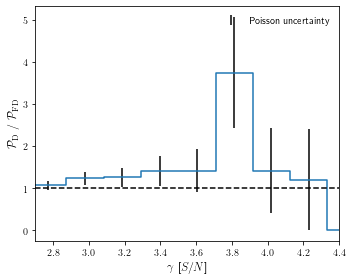

In [12]:
uns = uncertainties/(bin_widths*bins_FD[0]*len(data_real_P['SNR']))

plt.figure(figsize=(5,4))

plt.step(bin_centers, bins_D[0]/bins_FD[0], where='mid')
plt.xlabel(r'$\gamma$ [$S/N$]', fontsize = 12)
plt.ylabel(r'$\mathcal{P}_{\rm D}$ / $\mathcal{P}_{\rm FD}$ ', fontsize = 12)

plt.axhline(1, c = 'k', ls = '--')
plt.errorbar(bin_centers, bins_D[0]/bins_FD[0], yerr=uns, fmt=' ', color='k', label='Poisson uncertainty')

plt.legend(frameon=False)
plt.axis(xmin = 2.7, xmax = 4.4)
plt.tight_layout()
plt.savefig('../../plots/excess_pos_peaks.pdf', dpi = 300)
plt.show()

So, is the excess significant? Well by $\approx 2\sigma$...

### Which peak is most likely?
If one of the peaks is real, we can use the prior from the JWST observations to see which peak is most likely

In [13]:
candidates = data_real_P[(data_real_P['SNR']>3.7) & (data_real_P['SNR']<3.9)]
candidates

RA,DEC,FREQ_GHZ,X,Y,SNR,FLUX_MAX,BINNING
float64,float64,float64,float64,float64,float64,float64,int64
3.49908,-30.32502,254.0401,413.6,205.6,3.79,0.000703,3
3.49909,-30.32503,254.0088,402.8,197.9,3.72,0.000931,5
3.4985,-30.32519,254.2588,1011.7,7.8,3.84,0.000993,5
3.49855,-30.32484,255.0713,968.1,431.2,3.86,0.000889,5
3.49939,-30.32495,255.2275,94.6,295.2,3.86,0.001058,5
3.49909,-30.32504,254.0713,403.6,191.1,3.73,0.001162,7
3.49936,-30.32459,254.6025,125.2,724.1,3.72,0.001146,7
3.49935,-30.32459,254.6338,138.4,725.3,3.72,0.001274,9


In [14]:
z = 12.33 # from Zavala+2024
dz = 0.02 # from Zavala+2024

OIII_rest = 3393.01 * u.GHz
OIII_obsv = (c.c / (88*1e-6 *u.meter)).to(u.GHz)/(1+z)

df = dz/(z + 1) * OIII_obsv

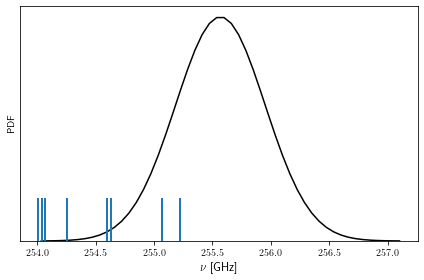

In [15]:
g1 = models.Gaussian1D(amplitude=0.2, mean=OIII_obsv, stddev=df)
xs = np.linspace(OIII_obsv - 4*df, OIII_obsv + 4*df, 50)

plt.plot(xs, g1(xs), c='k')
plt.axis(ymin = 0)
plt.xlabel(r'$\nu$ [GHz]', fontsize = 12)

for i in range(len(candidates)):
    plt.plot([candidates['FREQ_GHZ'][i], candidates['FREQ_GHZ'][i]], np.linspace(0,candidates['SNR']/np.nanmin(candidates['SNR'])-1,2), c = 'C0', linewidth = 2)
    
plt.yticks([])
plt.ylabel ('PDF')
plt.tight_layout()
plt.savefig('../../plots/JWST_pdf_peaks.pdf', dpi = 300)
plt.show()

Let's show the moment-0 map according to the most likeli peak. For this we will use the build in Jacked tools

In [16]:
import jacked
from astropy.coordinates import SkyCoord
from astropy.io import fits

In [17]:
#initilaize
tool = jacked.Jack(fname   = '../../data/Glass-z13.ms', # The file name of the visibilities, 
                   outdir  = '../../output/', #the directory to save the outputs in
                   fields  = ['3'], # Each visibility can have multiple fields, 
                   spws    = [['0']], # and each field can have multiple spws,
                   band    = 'Band7', # Band of the observation,
                   array   = 'C7', # which configuration the observation are taken in,
                   )
tool.outfile = '../../output/cubes/Glass-z13.im'

In [18]:
fname    = tool.outfile +'.fits'
hdu      =   fits.open(fname)
cube     = hdu[0].data[0]
header   = hdu[0].header

Dfreq    = header['CDELT3']
restfreq = header['CRVAL3']
freqs    = (np.arange(len(cube))*Dfreq + restfreq)/1e9    

In [19]:
index  = np.argmin(np.abs(freqs - np.amax(candidates['FREQ_GHZ'])))
di     = (candidates[-1]['BINNING'] - 1)//2

Position,  00h13m59.8536s -30d19m29.82s
Offset, 1.42 arcseconds


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


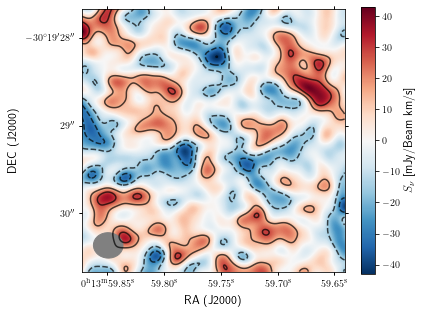

In [22]:
RA = candidates[np.argmax(candidates['FREQ_GHZ'])]['RA']
Dec = candidates[np.argmax(candidates['FREQ_GHZ'])]['DEC']

c1 = SkyCoord(3.498985*u.deg, -30.324767*u.deg, frame='icrs')
c2 = SkyCoord(RA*u.deg, Dec*u.deg, frame='icrs')
sep=c1.separation(c2)

print('Position, ', c2.to_string('hmsdms'))
print("Offset, {:.2f} arcseconds".format(sep.to(u.arcsec).value))

tool.plot_map(savedir = '../../plots/', moment = 'moment-0', channels = [index-di,index+di], box_size_arcsec=3, center_coord=(3.498985, -30.324767))